# 1. 라이브러리 Import 및 데이터 Read

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
# 경로 설정
os.chdir(r'C:\Users\user\Python_study\data')

In [3]:
# 분석 데이터 Read
data = pd.read_csv("bank-additional-full.csv", sep = ';')

data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# 카테고리형 변수를 수치화시키는 one hot encoding 방법론을 pd.get_dummies란 함수를 통해 실행
data = pd.get_dummies(data, columns = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome'])

In [5]:
# 목표 변수를 yes는 1, no는 0으로 수치화n(shap value 패키지 특성상 목표변수를 수치화시키지 않는다면 나중에 에러 발생)
data['y'] = np.where( data['y'] == 'no', 0, 1)

In [6]:
# 학습에 활용할 input 변수를 지정
input_var = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_no', 'default_unknown', 'default_yes',
       'housing_no', 'housing_unknown', 'housing_yes', 'loan_no',
       'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success']

# 2. XGBoost 학습

In [7]:
# XGBoost를 위한 패키지
from xgboost import XGBRegressor

xgb = XGBRegressor( n_estimators = 300, learning_rate=0.1 )

In [8]:
# XGBoost 모델을 train 데이터에서 학습
xgb.fit(data[input_var], data['y'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# 3. Shap Value 활용

### a) 변수중요도

In [10]:
# shap value를 위한 패키지
import shap

In [12]:
# 제작한 모델을 TreeExplainer 함수에 넣고, 학습한 train 데이터를 shap_values 함수에 넣음
# 원하는 변수중요도가 추출됨
explainer = shap.TreeExplainer(xgb)

In [13]:
shap_values = explainer.shap_values( data[input_var] )

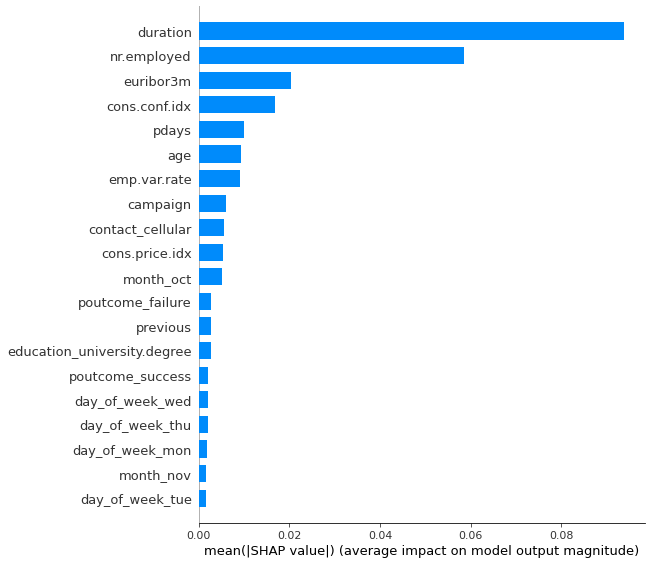

In [14]:
# 계산된 변수중요도를 summary_plot을 통해 시각화
shap.summary_plot( shap_values , data[input_var] , plot_type="bar" )

### b) dependence plot
- 특정 input 변수와 target 변수와의 관계를 표현하는 dependence plot을 그려주는 함수

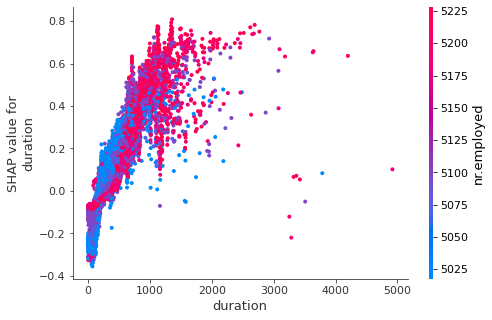

In [15]:
shap.dependence_plot( 'duration' , shap_values , data[input_var] )

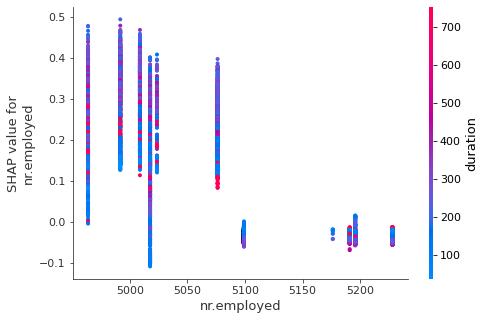

In [16]:
shap.dependence_plot( 'nr.employed' , shap_values , data[input_var] )

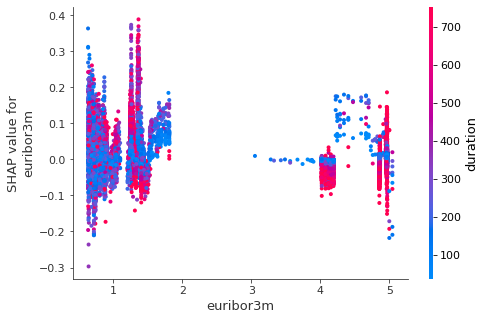

In [17]:
shap.dependence_plot( 'euribor3m' , shap_values , data[input_var] )

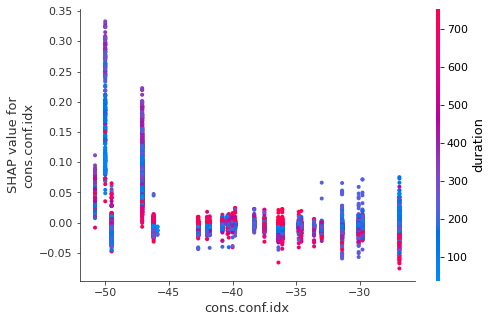

In [18]:
shap.dependence_plot( 'cons.conf.idx' , shap_values , data[input_var] )

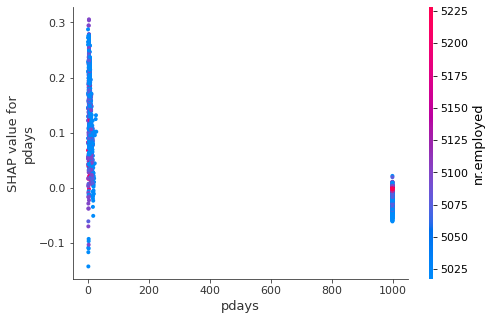

In [19]:
shap.dependence_plot( 'pdays' , shap_values , data[input_var] )

### c) force plot
- 특정 값이 어떻게 예측되었는지를 시각화하는 force plot을 그려주는 함수

In [20]:
prediction = xgb.predict(data[input_var])
data['pred'] = prediction

In [21]:
shap.initjs()
shap.force_plot( explainer.expected_value , shap_values[41187] , data[input_var].iloc[41187] )